# Imports

In [1]:
import requests
import json
import folium
import numpy as np
from sklearn.cluster import HDBSCAN
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import pandas as pd
import overpy
import os

## 1.1.Data preprocessing

Using [Overpass API](https://wiki.openstreetmap.org/wiki/Overpass_API) to query locations that fulfill the given conditions.

In [2]:
import overpy

In [3]:
api = overpy.Overpass()

# Query for all gas stations that are at less than road_distance=2km
# From a road classified as "autovía" (i.e motorway) in location=Granada
# Some other options for locations="Albacete, Galicia, Sevilla"

location = "Granada"
road_distance = "2000"  # (m)

query = '''
[out:json];
area[name='''+ location + '''][admin_level=8]->.where;
node(area.where)[highway=bus_stop];
out body;
>;
out skel qt;'''


# Selectin ALL amenities
query = '''
[out:json];
area[name='''+ location + '''][admin_level=8]->.granada;
(
  node(area.granada)[amenity](37.120, -3.650, 37.300, -3.570);
);
out body;
>;
out skel qt;
'''

response = api.query(query)

In [4]:
import pandas as pd

In [5]:
# Preparing the dataframe [id,latitude,longitude]
df = pd.DataFrame(
    columns=["id","lat","lon"])

for node in response.get_nodes():
    # Adding all the position information of nodes
    new_row = pd.DataFrame(
        {"id": node.id,
         "lat": node.lat,
         "lon": node.lon},
         index=[0])

    df = pd.concat([df,new_row],axis=0)

# Formatted information into a DataFrame, only for convenience
df.reset_index(inplace=True, drop=True)
print(df)

               id         lat         lon
0        83533572  37.1868974  -3.6036270
1        88144037  37.1946846  -3.6228425
2       267489671  37.1868624  -3.5919396
3       290912866  37.2016761  -3.6155480
4       290969327  37.1741866  -3.5852181
...           ...         ...         ...
5157  12533865237  37.1599351  -3.5829103
5158  12533867497  37.1595211  -3.5821030
5159  12533868467  37.1599004  -3.5828408
5160  12533869625  37.1594813  -3.5820298
5161  12533883729  37.1592425  -3.5773953

[5162 rows x 3 columns]


In [6]:
import matplotlib.pyplot as plt

Number of detected possible places: 5162


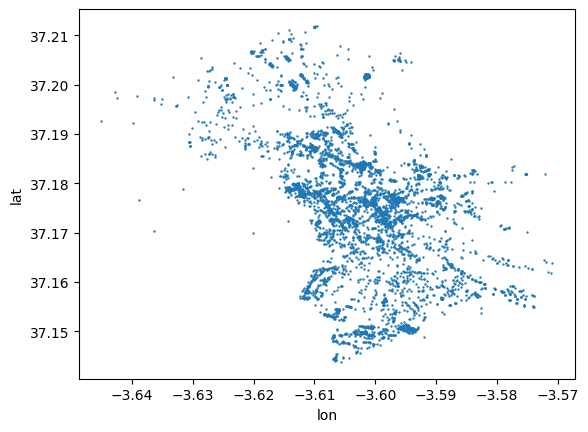

In [7]:
plt.scatter(x=df["lon"],y=df["lat"], s=0.5)
plt.xlabel("lon")
plt.ylabel("lat")
print("Number of detected possible places:", len(df.index))

## 1.2.Algorithm

In [8]:
import numpy as np
from sklearn.cluster import HDBSCAN
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler


Preprocessing: We will be using a clustering algorithm to non-unformlly sample the bus stops. The closer bus stops will be undersampled and the farther away from each other oversampled with respect to each other

c:\Users\Broiin\Documents\pasqal_challenge\.venv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Text(0.5, 1.0, 'Kmeans')

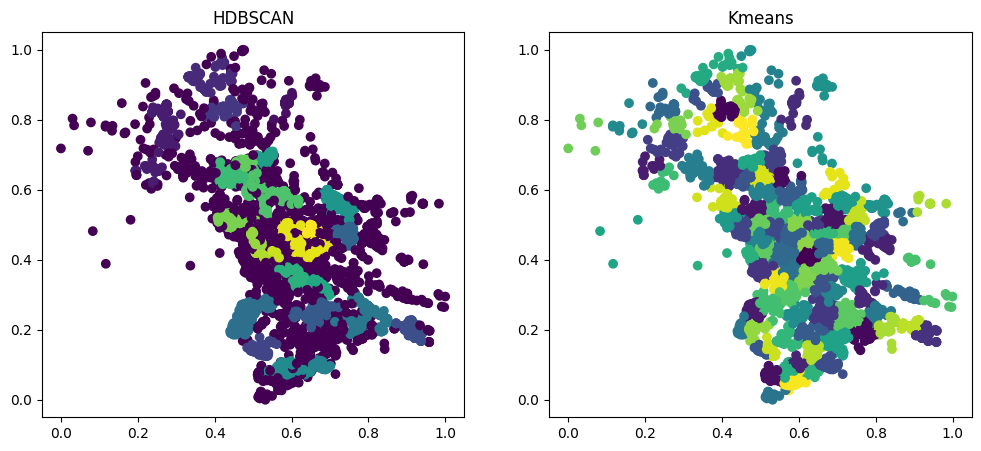

In [9]:

data_size = len(df.index)
# Normalizing data for epsilon selection

clusters = 100
min_cluster_size = int(data_size/clusters) # Min 1/40 per cluster
max_cluster_size = int(data_size/20) # Min 30 groups
min_samples = 10
epsilon = 0.0
clustering = HDBSCAN(min_cluster_size, min_samples, epsilon)
scaler = MinMaxScaler()
X = scaler.fit_transform(df[['lon','lat']].values)


fig, ax = plt.subplots(1, 2)
fig.set_size_inches((12,5))

labels = clustering.fit_predict(X)
ax[0].scatter(X.T[0], X.T[1], c=labels)
ax[0].set_title('HDBSCAN')

clustering = KMeans(clusters)

labels = clustering.fit_predict(X)

ax[1].scatter(X.T[0], X.T[1], c=labels)
ax[1].set_title('Kmeans')

Clearly Kmeans does a much better job without fine tuning. The only parameter to adjust, the number of clusters. We now reduce the data to
the size that we want

In [10]:
# We extract n samples from each cluster
unique_labels = np.unique(labels)
# first position is reserved for nonassigned data
n_cluster = np.zeros(len(unique_labels))
indices = np.indices(labels.shape)[0]
cluster_indices = []
max_cluster_size = int(100/len(unique_labels))

sample_indx = []

for i in range(len(unique_labels)):
  filter_labels = labels == unique_labels[i]
  cluster_indices = indices[filter_labels]
  n_cluster[i] = len(cluster_indices)

  # Now we sample max_cluster_size
  extract_size = np.amin([max_cluster_size, n_cluster[i]]).astype(int)
  sample_indx.extend(np.random.choice(cluster_indices, size=extract_size, replace=False))


final_data = pd.DataFrame(df.to_numpy()[sample_indx], columns=['id', 'lat', 'lon'])
print(final_data)


             id         lat         lon
0    9447748339  37.1708456  -3.5975220
1    7199858501  37.1998959  -3.6133957
2    8058203708  37.1566836  -3.5892250
3    5744223503  37.1866891  -3.6035803
4   10182120863  37.1475368  -3.6045451
..          ...         ...         ...
95   9502797291  37.1838123  -3.5933384
96   8859864309  37.1652719  -3.6050555
97  10731243705  37.1737209  -3.5931998
98  10149206306  37.1477711  -3.6010049
99   3500778378  37.1948886  -3.6125400

[100 rows x 3 columns]


## 1.3.Map and driving distances

As shown in the map, using "margin_limit=1." gives a network with much space between stations. This is an approach for a minimal, yet web-like, solution.

In [11]:
import folium

def map_show(data : pd.DataFrame, loc_coords):

  # Create a map centered on loc_coords [latitude, longitude]
  map = folium.Map(location=loc_coords, zoom_start=8)

  # Loop through the data and add markers for each location
  for i, row in data.iterrows():
      folium.Marker([row['lat'], row['lon']],
                    popup=row['id']).add_to(map)
  return map

means = final_data.mean()
means_lat_lon = [means[1], means[2]]
map_show(final_data, means_lat_lon)

C:\Users\Broiin\AppData\Local\Temp\ipykernel_10580\1921316064.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  means_lat_lon = [means[1], means[2]]


Now that fewer points are left, it is feasible to check the driving distances with the [OSRM API](http://project-osrm.org/docs/v5.5.1/api/) demo server.

In [12]:
# Let's check if the criteria is met for driving distance(<50km):
import requests
import json

Sending a query with the selected gas stations coordinates to OSRM API, an API desigend to calculate fastest driving distances (by car).

In [13]:
url = "http://router.project-osrm.org/table/v1/driving/"
routes = ""

# Query with longitude1,latitude1;longitude2,latitude2;...
for ind in final_data.index:
    routes += str(final_data["lon"][ind])+","+str(final_data["lat"][ind])+";"

routes = routes[:-1]
print(routes)

print("Query: ", routes + "...")
routes_response = requests.get(url+routes+"?annotations=distance")

-3.5975220,37.1708456;-3.6133957,37.1998959;-3.5892250,37.1566836;-3.6035803,37.1866891;-3.6045451,37.1475368;-3.5953807,37.1810661;-3.6091091,37.1812150;-3.6084716,37.1599165;-3.6306646,37.1883653;-3.5857844,37.1709899;-3.6011328,37.1505658;-3.5876264,37.1636673;-3.6010159,37.2019552;-3.6128539,37.1878252;-3.5740022,37.1550017;-3.6057285,37.1686085;-3.5963243,37.1591715;-3.5969442,37.1779011;-3.6277872,37.1918702;-3.6059997,37.1902463;-3.6114953,37.1777546;-3.5865103,37.1760748;-3.6034339,37.1772269;-3.5930756,37.1503701;-3.6173974,37.2041786;-3.5939143,37.1674148;-3.6100728,37.1871323;-3.6075037,37.1531894;-3.5998798,37.1554576;-3.6008421,37.1840306;-3.6017102,37.1764263;-3.5782150,37.1644213;-3.5960020,37.1723549;-3.6263294,37.2004644;-3.6043835,37.1713257;-3.5814087,37.1800715;-3.5888090,37.1746407;-3.6019784,37.1682764;-3.6031142,37.1456704;-3.6111107,37.1578087;-3.5835948,37.1602805;-3.6076501,37.1948093;-3.6189460,37.1879644;-3.6100238,37.2041761;-3.6055841,37.1828288;-3.6069685

In [14]:
dist_table_json = routes_response.json()
try:
    dist_table=np.array(dist_table_json["distances"])/1000 # meters to km
except:
    print("Too big")


np.savetxt(os.path.join("data", 'matriz-rutas-granada'), dist_table)
print(dist_table)


[[ 0.      6.3727  2.6409 ...  2.5815  3.5252  5.0666]
 [ 4.0897  0.      6.5711 ...  4.5747  9.2284  0.8654]
 [ 2.5951  7.0652  0.     ...  5.5321  3.0987  5.759 ]
 ...
 [ 1.3603  4.5277  3.2521 ...  0.      4.1363  4.4808]
 [ 4.3278 11.7157  1.7831 ...  5.6852  0.      6.3346]
 [ 4.0948  1.3352  5.7329 ...  4.2769  8.3902  0.    ]]


In [15]:
#HERE EXECUTE QUBOSOLVER

# 1.4 Visualize QUBOSolver

In [16]:
def draw_line(df, line, color, map=None):
    means = df.mean()
    loc_coords = [means.iloc[1], means.iloc[2]]
    if map == None:
        map = folium.Map(location=loc_coords, zoom_start=8)
    # Get all connected positions from line adj matrix
    nonzero = np.nonzero(line)
    for i in range(len(nonzero[0])):
        indx1 = nonzero[0][i]
        indx2 = nonzero[1][i]

        pos_1 = df.iloc[indx1][['lat','lon']].values
        pos_2 = df.iloc[indx2][['lat','lon']].values
        folium.Marker(pos_1).add_to(map)
        folium.Marker(pos_2).add_to(map)
        colorline = folium.features.PolyLine([pos_1,pos_2], color=color)
        colorline.add_to(map)
    return map
line = np.genfromtxt(os.path.join("results", 'Line0.dat'))
map = draw_line(final_data, line, 'red')
line = np.genfromtxt(os.path.join("results", 'Line1.dat'))
map = draw_line(final_data, line, 'blue', map)
line = np.genfromtxt(os.path.join("results", 'Line2.dat'))
map = draw_line(final_data, line, 'green', map)
map